In [1]:
import math
import torch
import random
import warnings
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
%matplotlib inline

## Data generation

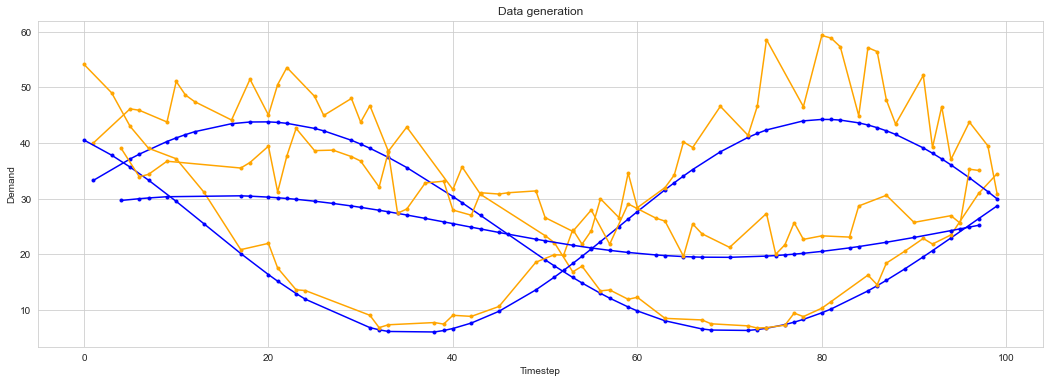

In [2]:
NUM_TIMESTEPS = 100
NUM_CUSTOMERS = 100
assert NUM_CUSTOMERS >= 3

def data_generating_model():
    t = torch.arange(0, NUM_TIMESTEPS).float()    # Timesteps
    X = torch.rand(NUM_CUSTOMERS, NUM_TIMESTEPS)  # Random discounts

    # Random sine wave baseline demand 
    amplitude = torch.rand((NUM_CUSTOMERS, 1)) * 20
    frequency = torch.rand((NUM_CUSTOMERS, 1)) * 0.03 * math.pi
    phase = torch.rand((NUM_CUSTOMERS, 1)) * math.pi
    B = 25 + amplitude * torch.sin(frequency * t + phase)
    
    # Random customer-specific elasticity
    eps = pyro.sample("eps", dist.Normal(0.5, 0.25).expand([NUM_CUSTOMERS]))
    
    # Noisy demand depending on discount and elasticity
    mu = B * (1 + eps.view(-1, 1) * X)
    sigma = pyro.sample("sigma", dist.Normal(0, 0.1).expand([NUM_CUSTOMERS, NUM_TIMESTEPS]))
    Y = pyro.sample("y", dist.Normal(mu, sigma))
    
    # Missing data
    mask = dist.Bernoulli(0.5).sample([NUM_CUSTOMERS, NUM_TIMESTEPS])
    drop_data = lambda Z: [z[m > 0] for z, m in zip(Z, mask)]
    T, B, X, Y = [drop_data(Z) for Z in (t.repeat(NUM_CUSTOMERS, 1), B, X, Y)]
    return T, B, X, Y

T, B, X, Y = data_generating_model()

fig, ax = plt.subplots(figsize=(18, 6))
ax.set(xlabel="Timestep", ylabel="Demand")
ax.set_title("Data generation")

for i in range(3):
    ax.plot(T[i], B[i], color="blue", marker=".")
    ax.plot(T[i], Y[i], color="orange", marker=".")

## Baseline estimator

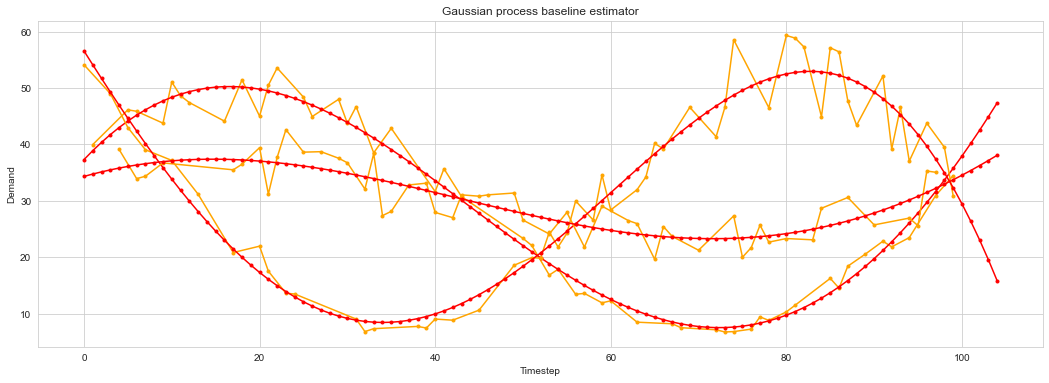

In [3]:
rbf = RBF(length_scale_bounds=(100, 1000))
noise = WhiteKernel(noise_level_bounds=(0.1, 1))
kernel = ConstantKernel() * rbf + noise

fig, ax = plt.subplots(figsize=(18, 6))
ax.set(xlabel="Timestep", ylabel="Demand")
ax.set_title("Gaussian process baseline estimator")

for i in range(3):
    gp = GaussianProcessRegressor(kernel=kernel)

    t, y = T[i].reshape(-1, 1), Y[i].reshape(-1, 1)
    t_test = np.arange(NUM_TIMESTEPS + 5).reshape(-1, 1)
    gp.fit(t, y)
    y_hat = gp.predict(t_test)

    ax.plot(t, y, color="orange", marker=".")
    ax.plot(t_test, y_hat, color="red", marker=".")

In [4]:
class BaselineEstimator:
    def fit(self, T, Y):
        """Fit baseline estimator: one Gaussian process per customer.
        
        :param T: list of timesteps for each customer containing 
            num_customers torch.Tensor of shape (num_timesteps,)
        :param Y: list of observed demand for each customer containing
            num_customers torch.Tensor of shape (num_timesteps,)
        """
        rbf = RBF(length_scale_bounds=(100, 1000))
        noise = WhiteKernel(noise_level_bounds=(0.1, 1))
        kernel = ConstantKernel() * rbf + noise
        
        self.gps = [GaussianProcessRegressor(kernel=kernel) for _ in T]
        for (gp, t, y) in zip(self.gps, T, Y):
            t, y = t.reshape(-1, 1), y.reshape(-1, 1)
            gp.fit(t, y)
            
    def predict(self, T):
        """Predict baseline demand for each customer at the given timesteps.
        
        :param T: list of timesteps for each customer containing 
            num_customers torch.Tensor of shape (num_timesteps,)
        :return: list of baseline predictions for each customer containing 
            num_customers torch.Tensor of shape (num_timesteps,)
        """
        return [torch.tensor(gp.predict(t.reshape(-1, 1))).flatten() 
                for (gp, t) in zip(self.gps, T)]
    
    def predict_timestep(self, t):
        """Predict baseline demand for each customer at the given timestep.
        
        :param t: timestep integer
        :return: predicted baseline demand torch.Tensor of shape (num_customers,)
        """
        t = np.array(t).reshape(1, 1)
        return torch.tensor([gp.predict(t)[0, 0] for gp in self.gps])

## Hierarchical elasticity model

In [5]:
# Predict baseline demand
baseline = BaselineEstimator()
baseline.fit(T, Y)
B = baseline.predict(T)

customer_idx = [(i * torch.ones_like(t)).long() for i, t in enumerate(T)]
x, y, b, customer_idx = [torch.cat(Z) for Z in (X, Y, B, customer_idx)]
r = y / b  # Demand shock

In [6]:
# Individual linear model
def model_individual(x, customer_idx, r=None, batch_size=5000):
    with pyro.plate("plate_param", size=NUM_CUSTOMERS):
        alpha = pyro.sample("alpha", dist.Normal(0, 1))
        eps = pyro.sample("eps", dist.Normal(0, 1))
        
    # Subsample batch
    n = min(len(x), batch_size)
    with pyro.plate("plate_obs", size=len(x), subsample_size=n) as idx:
        x, customer_idx = x[idx], customer_idx[idx]
        if r is not None:
            r = r[idx]
        mu = alpha[customer_idx] + eps[customer_idx] * x
        sigma = pyro.sample("sigma", dist.HalfCauchy(1))
        pyro.sample("r", dist.Normal(mu, sigma), obs=r)
        
# Diagonal normal variational posterior
guide_individual = AutoDiagonalNormal(model_individual)
    
# Stochastic variational inference
optimizer = Adam({"lr": 0.01})
svi = SVI(model_individual, guide_individual, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()
for step in range(5001):
    loss = svi.step(x, customer_idx, r)
    if step % 500 == 0:
        print(f"Step {step}: loss = {loss:.2f}")

# Posterior predictive
predictive_individual = Predictive(model_individual, guide=guide_individual, num_samples=1000)
with torch.no_grad():
    samples_individual = predictive_individual(x, customer_idx)

Step 0: loss = 20164.98
Step 500: loss = 2473.78
Step 1000: loss = 2332.88
Step 1500: loss = 2512.74
Step 2000: loss = 2066.05
Step 2500: loss = 2158.52
Step 3000: loss = 2483.51
Step 3500: loss = 1977.21
Step 4000: loss = 2196.83
Step 4500: loss = 2364.51
Step 5000: loss = 3118.35


In [7]:
# Hierarchical linear model
def model_hierarchical(x, customer_idx, r=None, batch_size=5000):
    # Hyperpriors
    alpha_loc = pyro.sample("alpha_loc", dist.Normal(0, 1))
    alpha_scale = pyro.sample("alpha_scale", dist.HalfCauchy(1))
    eps_loc = pyro.sample("eps_loc", dist.Normal(0, 1))
    eps_scale = pyro.sample("eps_scale", dist.HalfCauchy(1))
    
    # Non-centered parameterization
    with pyro.plate("plate_param", size=NUM_CUSTOMERS):
        alpha_offset = pyro.sample("alpha_offset", dist.Normal(0, 1))
        eps_offset = pyro.sample("eps_offset", dist.Normal(0, 1))
        alpha = pyro.deterministic("alpha", alpha_loc + alpha_offset * alpha_scale)
        eps = pyro.deterministic("eps", eps_loc + eps_offset * eps_scale)
            
    n = min(len(x), batch_size)
    with pyro.plate("plate_obs", size=len(x), subsample_size=n) as idx:
        x, customer_idx = x[idx], customer_idx[idx]
        if r is not None:
            r = r[idx]
        mu = alpha[customer_idx] + eps[customer_idx] * x
        sigma = pyro.sample("sigma", dist.HalfCauchy(1))
        pyro.sample("r", dist.Normal(mu, sigma), obs=r)
        
guide_hierarchical = AutoDiagonalNormal(model_hierarchical)
    
optimizer = Adam({"lr": 0.01})
svi = SVI(model_hierarchical, guide_hierarchical, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()
for step in range(5001):
    loss = svi.step(x, customer_idx, r)
    if step % 500 == 0:
        print(f"Step {step}: loss = {loss:.2f}")
        
predictive_hierarchical = Predictive(model_hierarchical, guide=guide_hierarchical, num_samples=1000)
with torch.no_grad():
    samples_hierarchical = predictive_hierarchical(x, customer_idx)

Step 0: loss = 17509.25
Step 500: loss = 1838.49
Step 1000: loss = 1580.78
Step 1500: loss = 1442.58
Step 2000: loss = 1527.59
Step 2500: loss = 1355.49
Step 3000: loss = 1535.43
Step 3500: loss = 1418.20
Step 4000: loss = 1741.49
Step 4500: loss = 1611.85
Step 5000: loss = 1587.83


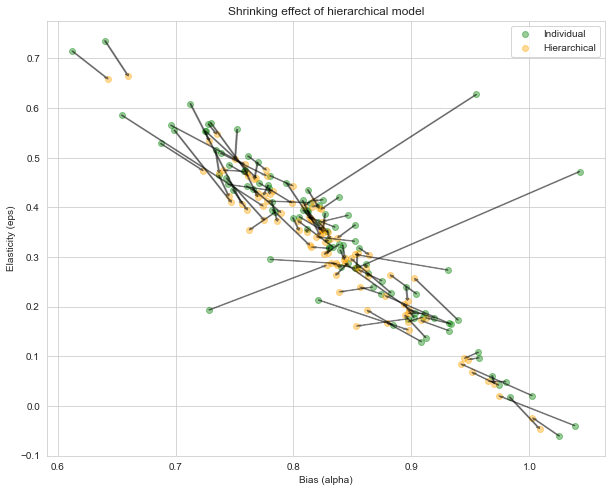

In [8]:
# Visualize shrinking effect of hierarchical model
def plot_shrinking(alpha_individual, alpha_hierarchical, eps_individual, eps_hierarchical):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, xlabel='Bias (alpha)', ylabel='Elasticity (eps)', 
                         title='Shrinking effect of hierarchical model')
    ax.scatter(alpha_individual, eps_individual, c='green', alpha=0.4, label='Individual')
    ax.scatter(alpha_hierarchical, eps_hierarchical, c='orange', alpha=0.4, label='Hierarchical')
    for i in range(NUM_CUSTOMERS):  
        ax.arrow(alpha_individual[i], eps_individual[i], 
                 alpha_hierarchical[i] - alpha_individual[i], eps_hierarchical[i] - eps_individual[i], 
                 fc="k", ec="k", length_includes_head=True, alpha=0.4)
    ax.legend()

alpha_individual = samples_individual['alpha'].mean(axis=0)
alpha_hierarchical = samples_hierarchical['alpha'].mean(axis=0)
eps_individual = samples_individual['eps'].mean(axis=0)
eps_hierarchical = samples_hierarchical['eps'].mean(axis=0)
plot_shrinking(alpha_individual, alpha_hierarchical, eps_individual, eps_hierarchical)

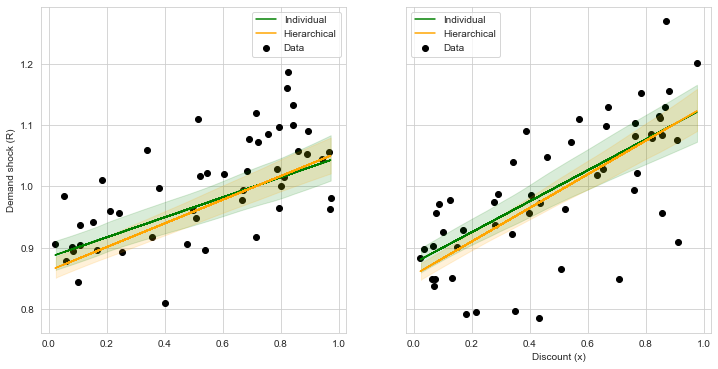

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
axes[0].set_ylabel('Demand shock (R)')
axes[1].set_xlabel('Discount (x)')

for i in range(2):
    ax = axes[i]
    x, y, b = X[i], Y[i], B[i]
    r = y / b
    
    alpha_individual = samples_individual['alpha'][:, i].view(-1, 1)
    eps_individual = samples_individual['eps'][:, i].view(-1, 1)
    mu_individual = alpha_individual + eps_individual * x
    
    alpha_hierarchical = samples_hierarchical['alpha'][:, i].view(-1, 1)
    eps_hierarchical = samples_hierarchical['eps'][:, i].view(-1, 1)
    mu_hierarchical = alpha_hierarchical + eps_hierarchical * x
    
    ax.scatter(x, r, label='Data', color='black')
    
    ax.plot(x, mu_individual.mean(dim=0), color='green', label='Individual')
    az.plot_hpd(x, mu_individual, color='green', credible_interval=0.95,
                fill_kwargs={'alpha': 0.15}, ax=ax)
    
    ax.plot(x, mu_hierarchical.mean(dim=0), color='orange', label='Hierarchical')
    az.plot_hpd(x, mu_hierarchical, color='orange', credible_interval=0.95,
                fill_kwargs={'alpha': 0.15}, ax=ax)
    ax.legend()

## Active elasticity learning and discount optimization

In [10]:
class DiscountOptimizer:  
    def __init__(self, num_customers, batch_size=5000):
        self.baseline = BaselineEstimator()
        
        # Hierarchical linear model
        def elasticity_model(x, customer_idx, r=None, batch_size=batch_size):
            # Hyperpriors
            alpha_loc = pyro.sample("alpha_loc", dist.Normal(0, 1))
            alpha_scale = pyro.sample("alpha_scale", dist.HalfCauchy(1))
            eps_loc = pyro.sample("eps_loc", dist.Normal(0, 1))
            eps_scale = pyro.sample("eps_scale", dist.HalfCauchy(1))

            # Non-centered parameterization
            with pyro.plate("plate_param", size=num_customers):
                alpha_offset = pyro.sample("alpha_offset", dist.Normal(0, 1))
                eps_offset = pyro.sample("eps_offset", dist.Normal(0, 1))
                alpha = pyro.deterministic("alpha", alpha_loc + alpha_offset * alpha_scale)
                eps = pyro.deterministic("eps", eps_loc + eps_offset * eps_scale)

            # Subsample batch
            n = min(len(x), batch_size)
            with pyro.plate("plate_obs", size=len(x), subsample_size=n) as idx:
                x, customer_idx = x[idx], customer_idx[idx]
                if r is not None:
                    r = r[idx]
                mu = alpha[customer_idx] + eps[customer_idx] * x
                sigma = pyro.sample("sigma", dist.HalfCauchy(1))
                pyro.sample("r", dist.Normal(mu, sigma), obs=r)
                
        self.model = elasticity_model
    
    def fit(self, T, X, Y):
        """Fit elasticy model.
        
        :param T: list of timesteps for each customer containing num_customers 
            torch.Tensor of shape (num_timesteps,)
        :param X: list of discounts for each customer containing num_customers 
            torch.Tensor of shape (num_timesteps,)
        :param Y: list of observed demand for each customer containing num_customers 
            torch.Tensor of shape (num_timesteps,)
        """
        self.baseline.fit(T, Y)
        
        B = baseline.predict(T)
        customer_idx = [(i * torch.ones_like(t)).long() for i, t in enumerate(T)]
        x, y, b, customer_idx = [torch.cat(Z) for Z in (X, Y, B, customer_idx)]
        r = y / b  # Demand shock
        
        # Diagonal normal variational posterior
        self.guide = AutoDiagonalNormal(self.model)

        # Estimate posterior with stochastic variational inference
        print("Fitting discount optimizer with SVI")
        optimizer = Adam({"lr": 0.01})
        svi = SVI(self.model, self.guide, optimizer, loss=Trace_ELBO())
        pyro.clear_param_store()
        for step in range(5001): 
            loss = svi.step(x, customer_idx, r)
            if step % 500 == 0:
                print(f"Step {step}: loss = {loss:.2f}")
    
    def predict(self, t, x, num_samples=1000):
        """Sample posterior demand for each customer at the given timestep.
        
        :param t: timestep integer
        :param x: discounts torch.Tensor (num_discounts,)
        :return: predicted baseline demand torch.Tensor of shape (num_customers,)
        :return: samples from posterior over demand shock r torch.Tensor of shape
            (num_samples, num_customers, num_discounts)
        """
        ###################### THIS FUNCTION IS PSEUDOCODE ######################
        # Posterior predictive distribution
        self.predictive = Predictive(self.model, guide=guide, num_samples=num_samples)
        
        # Use self.baseline to compute baseline demand b
        # Use self.predictive to sample demand shock r given for all customers and all x
        # => Can't get self.predictive to predict on new data yet because Pyro plates are annoying
        return b, r_samples
    
    def act(self, t, method="UCB", grid_size=100):
        """Compute the best discount for each customer at the given timestep.
        
        :param t:  timestep integer
        :param method: active learning algorithm
        :return: discounts torch.Tensor of shape (num_customers,)
        """
        ###################### THIS FUNCTION IS PSEUDOCODE ######################
        assert method in ['UCB', 'EIG', 'TS']
        
        # Grid search on discount in [0, 1]
        x = torch.linspace(0, 1, grid_size)
        
        b, r_samples = self.predict(t, x)  
        # r_samples.shape = (num_samples, num_customers, grid_size)
        # b.shape = (num_customers,)
        y_samples = b.view(-1, 1) * r_samples
        revenue_samples = y_samples * (1 - x)
        
        if method == 'UCB':
            # Upper confidence bound
            revenue_mu = revenue_samples.mean(dim=0)
            revenue_std = revenue_samples.std(dim=0)
            idx = (revenue_mu + revenue_std).argmax(dim=-1)
        if method == 'EIG':
            # Expected information gain
            # Love David MacKay!
            idx = r_samples.std(dim=0).argmax(dim=-1)
        if method == 'TS':
            # Thompson sampling
            idx = random.choice(revenue_samples).argmax(dim=-1)
            
        return x[idx]

In [11]:
discount_optimizer = DiscountOptimizer(NUM_CUSTOMERS)
discount_optimizer.fit(T, X, Y)

Fitting discount optimizer with SVI
Step 0: loss = 20051.28
Step 500: loss = 2423.08
Step 1000: loss = 2340.51
Step 1500: loss = 1928.80
Step 2000: loss = 1613.78
Step 2500: loss = 1807.31
Step 3000: loss = 1602.44
Step 3500: loss = 1500.32
Step 4000: loss = 1749.19
Step 4500: loss = 1499.13
Step 5000: loss = 1372.23


## Future work
- More expressive variational posterior
- More computationally efficient baseline estimator
- More expressive elasticity model (non-linear) 
- Incorporate side information (like competitor prices)
- Remove some simplifying assumptions: e.g. discount $x_i(t)$ only influences demand at next step $y_i(t+1)$ through the trend $T_i(t+1)$; we could use reinforcement learning instead